In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

## Data Load

In [2]:
start = datetime.now()
if not os.path.isfile('metadata.csv'):
    data = open('metadata.csv', mode='w')
    row = list()
    files=['D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_1.txt','D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_2.txt', 
           'D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_3.txt', 'D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_1.txt...
Done.

Reading ratings from D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_2.txt...
Done.

Reading ratings from D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_3.txt...
Done.

Reading ratings from D:/12S17037_Nita S W Sirait_Sistem Informasi/Kuliah/semester 7/dami/proyek/combined_data_4.txt...
Done.

Time taken : 0:06:45.750975


In [3]:
print("membuat dataframe metadata.csv")
df = pd.read_csv('metadata.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done..\n')

# we are arranging the ratings according to time.
print('Mengurutkan dataframe berdasarkan tanggal')
df.sort_values(by='date', inplace=True)
print('Done..')

membuat dataframe metadata.csv
Done..

Mengurutkan dataframe berdasarkan tanggal
Done..


In [4]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df.head(50)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11
20393918,3870,510180,2,1999-11-11
46516889,8357,510180,4,1999-11-11
89491833,15894,510180,3,1999-11-11
49973109,9003,510180,3,1999-11-11
51805125,9392,510180,3,1999-11-11


In [6]:
df.tail()

,movie,user,rating,date
49939086,8993,2183787,4,2005-12-31
42072268,7430,258170,4,2005-12-31
47098649,8467,1534359,5,2005-12-31
55621336,10168,2543295,2,2005-12-31
25464092,4736,1346243,5,2005-12-31


## Cek NaN

In [7]:
print("tidak ada NaN pada dataframe : ", sum(df.isnull().any()))

tidak ada NaN pada dataframe :  0


## Cek Jumlah Baris Data 

In [8]:
print("Total data ")
print("\nTotal ratings :",df.shape[0])
print("Total Users   :", len(np.unique(df.user)))
print("Total movies  :", len(np.unique(df.movie)))

Total data 

Total ratings : 100480507
Total Users   : 480189
Total movies  : 17770


## Cek Nilai yang hilang

In [10]:
np.where(df.isnull())

(array([], dtype=int64), array([], dtype=int64))

## Menghapus Nilai yang duplikat

In [9]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("Terdapat {} Nilai rating pada metadata..".format(dups))

Terdapat 0 Nilai rating pada metadata..


## Exploratory Data Analysis pada Data 

In [14]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"



## Distribusi dari ratings 

C:\Users\Personal\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Personal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


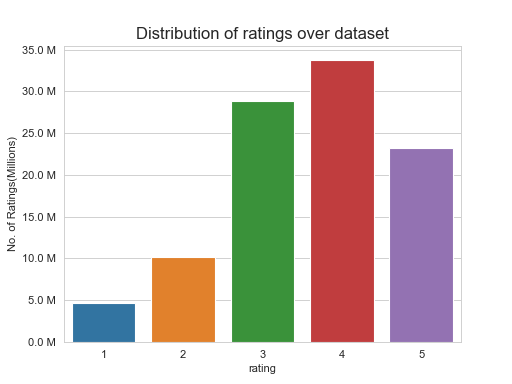

In [16]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over dataset', fontsize=15)
sns.countplot(df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [17]:
pd.options.mode.chained_assignment = None  # default='warn'

df['day_of_week'] = df.date.dt.weekday_name

df.tail()

,movie,user,rating,date,day_of_week
49939086,8993,2183787,4,2005-12-31,Saturday
42072268,7430,258170,4,2005-12-31,Saturday
47098649,8467,1534359,5,2005-12-31,Saturday
55621336,10168,2543295,2,2005-12-31,Saturday
25464092,4736,1346243,5,2005-12-31,Saturday


## Jumlah rating setiap bulan 

C:\Users\Personal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


<IPython.core.display.Javascript object>


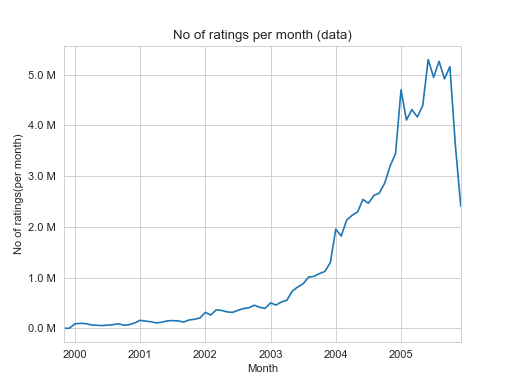

In [24]:
ax = df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

## Analsis Ratings yang diberi oleh User

In [19]:
no_of_rated_movies_per_user = df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
Name: rating, dtype: int64

In [20]:
no_of_rated_movies_per_user.describe()

count    480189.000000
mean        209.251997
std         302.339155
min           1.000000
25%          39.000000
50%          96.000000
75%         259.000000
max       17653.000000
Name: rating, dtype: float64

## Analisis Ratings dari sebuah Movie oleh User

<IPython.core.display.Javascript object>


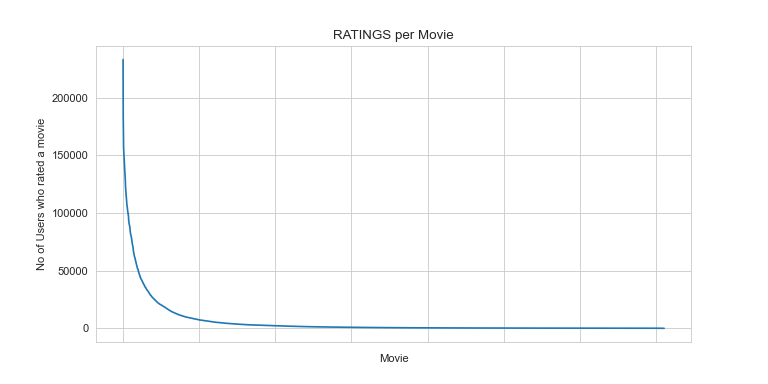

In [21]:
no_of_ratings_per_movie = df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

## Jumlah Rating setiap hari dalam seminggu

C:\Users\Personal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<IPython.core.display.Javascript object>


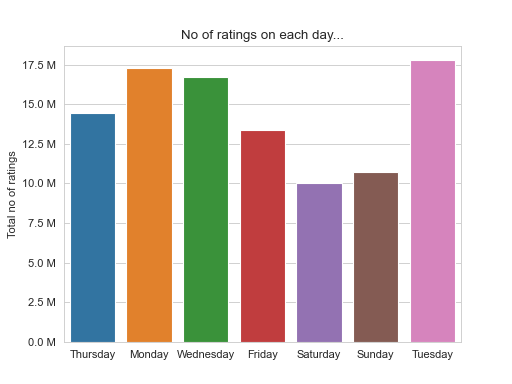

In [22]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [23]:
avg_week_df = df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.605892
Monday       3.597735
Saturday     3.614754
Sunday       3.616449
Thursday     3.604305
Tuesday      3.595808
Wednesday    3.604725
Name: rating, dtype: float64


